In [45]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append("/content/drive/MyDrive/kubig_financial/finrl")

# install required packages
# !pip install gym
# !pip install stockstats
# !pip install gymnasium
# !pip install stable_baselines3
# !pip install alpaca_trade_api
# !pip install exchange_calendars
# !pip install pyfolio
# !pip install matplotlib
# !pip install swig
# !pip install wrds
# !pip install pyportfolioopt
# !pip install --upgrade ipykernel
# !apt-get update -y -qq && apt-get install -y -qq cmake libopenmpi-dev python3-dev zlib1g-dev libgl1-mesa-glx swig

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime
from tqdm import tqdm

%matplotlib inline
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from stable_baselines3.common.logger import configure
from finrl.meta.data_processor import DataProcessor

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from pprint import pprint

import itertools

from finrl import config
from finrl import config_tickers
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)
check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class moving_avg(torch.nn.Module):

    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = torch.nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        x = torch.cat([front, x, end], dim=1)
        x = self.avg(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)
        return x

class series_decomp(torch.nn.Module):

    def __init__(self, kernel_size):
        super(series_decomp, self).__init__()
        self.moving_avg = moving_avg(kernel_size, stride=1)

    def forward(self, x):
        moving_mean = self.moving_avg(x)
        residual = x - moving_mean
        return moving_mean, residual

class LTSF_DLinear(torch.nn.Module):

    def __init__(self, window_size, forcast_size, kernel_size, individual, feature_size):
        super(LTSF_DLinear, self).__init__()
        self.window_size = window_size
        self.forcast_size = forcast_size
        self.decompsition = series_decomp(kernel_size)
        self.individual = individual
        self.channels = feature_size
        if self.individual:
            self.Linear_Seasonal = torch.nn.ModuleList()
            self.Linear_Trend = torch.nn.ModuleList()
            for i in range(self.channels):
                self.Linear_Trend.append(torch.nn.Linear(self.window_size, self.forcast_size))
                self.Linear_Trend[i].weight = torch.nn.Parameter((1/self.window_size)*torch.ones([self.forcast_size, self.window_size]))
                self.Linear_Seasonal.append(torch.nn.Linear(self.window_size, self.forcast_size))
                self.Linear_Seasonal[i].weight = torch.nn.Parameter((1/self.window_size)*torch.ones([self.forcast_size, self.window_size]))
        else:
            self.Linear_Trend = torch.nn.Linear(self.window_size, self.forcast_size)
            self.Linear_Trend.weight = torch.nn.Parameter((1/self.window_size)*torch.ones([self.forcast_size, self.window_size]))
            self.Linear_Seasonal = torch.nn.Linear(self.window_size,  self.forcast_size)
            self.Linear_Seasonal.weight = torch.nn.Parameter((1/self.window_size)*torch.ones([self.forcast_size, self.window_size]))

    def forward(self, x):
        trend_init, seasonal_init = self.decompsition(x)
        trend_init, seasonal_init = trend_init.permute(0,2,1), seasonal_init.permute(0,2,1)
        if self.individual:
            trend_output = torch.zeros([trend_init.size(0), trend_init.size(1), self.forcast_size], dtype=trend_init.dtype).to(trend_init.device)
            seasonal_output = torch.zeros([seasonal_init.size(0), seasonal_init.size(1), self.forcast_size], dtype=seasonal_init.dtype).to(seasonal_init.device)
            for idx in range(self.channels):
                trend_output[:, idx, :] = self.Linear_Trend[idx](trend_init[:, idx, :])
                seasonal_output[:, idx, :] = self.Linear_Seasonal[idx](seasonal_init[:, idx, :])
        else:
            trend_output = self.Linear_Trend(trend_init)
            seasonal_output = self.Linear_Seasonal(seasonal_init)
        x = seasonal_output + trend_output
        return x.permute(0,2,1)


class Windowed_Dataset(Dataset):

    def __init__(self, data, window_size, forcast_size):
        self.data = data
        self.window_size = window_size
        self.forcast_size = forcast_size

    def __len__(self):
        return len(self.data) - self.window_size - self.forcast_size

    def __getitem__(self, idx):
        return torch.from_numpy(self.data[idx:idx+self.window_size].values).type(torch.FloatTensor), torch.from_numpy(self.data[idx+self.window_size:idx+self.window_size+self.forcast_size].values).type(torch.FloatTensor)



class dlinear_main():

  def __init__(self, TRADE_END_DATE = '2023-05-05'):
    self.TRAIN_START_DATE = '2009-01-01'
    self.TRAIN_END_DATE = '2021-10-01'
    self.TRADE_START_DATE = '2021-10-01'
    self.PREDICTION_START_DATE = '2010-01-01'

    self.TRADE_END_DATE = TRADE_END_DATE
    self.tickers = ['XLB','XLE','XLF','XLI','XLK','XLP','XLU','XLV','XLY']


  def preprocessing(self, model, FORCAST_SIZE = 30):
    self.FORCAST_SIZE = FORCAST_SIZE
    self.model = model

    TRAIN_START_DATE = self.TRAIN_START_DATE
    TRAIN_END_DATE = self.TRAIN_END_DATE
    TRADE_START_DATE = self.TRADE_START_DATE
    TRADE_END_DATE = self.TRADE_END_DATE
    PREDICTION_START_DATE = self.PREDICTION_START_DATE
    tickers = self.tickers

    df = YahooDownloader(start_date = TRAIN_START_DATE,
                     end_date = TRADE_END_DATE,
                     ticker_list = tickers).fetch_data()

    data_for_pred = pd.DataFrame(index = range(len(df[df.tic==tickers[0]])), columns = tickers)
    data_for_pred['date'] = df.date.unique()
    for tic in tickers:
        data_for_pred[tic] = df[df.tic==tic].close.values

    prediction_start_index = data_for_pred[data_for_pred['date'] >= PREDICTION_START_DATE].index[0]
    test_start_index = data_for_pred[data_for_pred['date'] >= TRADE_START_DATE].index[0]

    print('prediction_start_index',prediction_start_index)
    print('test_start_index',test_start_index)

    idx_date = data_for_pred['date']
    data_for_pred = data_for_pred.drop('date',axis=1)

    WINDOW_SIZE = prediction_start_index
    self.FORCAST_SIZE = FORCAST_SIZE
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    self.device = device

    train_dataset = data_for_pred[:test_start_index]
    test_dataset = data_for_pred[test_start_index-WINDOW_SIZE:]
    print(len(train_dataset),len(test_dataset))

    WD_train = Windowed_Dataset(train_dataset, WINDOW_SIZE, FORCAST_SIZE)
    WD_test = Windowed_Dataset(test_dataset, WINDOW_SIZE, FORCAST_SIZE)
    WD_all = Windowed_Dataset(data_for_pred, WINDOW_SIZE, FORCAST_SIZE)
    print(len(WD_train), len(WD_test), len(WD_all))

    train_loader = DataLoader(WD_train, batch_size=32, shuffle=False)
    test_loader = DataLoader(WD_test, batch_size=32, shuffle=False)
    all_loader = DataLoader(WD_all, batch_size=32, shuffle=False)
    self.train_loader = train_loader
    self.test_loader = test_loader
    self.all_loader = all_loader
    print('test_loader',len(test_loader))

    batch = next(iter(train_loader))
    print(batch[0].shape)
    print(WINDOW_SIZE)
    print(FORCAST_SIZE)

    return test_dataset, WINDOW_SIZE, data_for_pred

  def train(self, model, epochs, tolerance=0.0001):

    self.model = model
    self.epochs = epochs
    self.tolerance = tolerance

    epochs = self.epochs
    tolerance = self.tolerance
    model = self.model
    train_loader = self.train_loader
    device = self.device

    criterion = nn.MSELoss().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    self.criterion = criterion
    self.optimizer = optimizer

    model.train()
    train_loss = 0
    for epoch in tqdm(range(epochs)):
        for X, y in train_loader:
            X = X.to(device)
            y = y.to(device)
            optimizer.zero_grad()
            output = model(X)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        if epoch % 10 == 0:
            print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch+1, loss.item()))
        if train_loss < tolerance:
            print('Training Loss: {:.6f}'.format(loss.item()))
            break
        train_loss = 0

    return model

  def test(self, model, flag):

    self.model = model

    device = self.device
    model = self.model
    test_loader = self.test_loader
    all_loader = self.all_loader
    criterion = nn.MSELoss().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    if flag == 1:
      loader = all_loader
    else: loader = test_loader

    model.eval()
    test_loss = 0
    predictions = []
    for X, y in tqdm(loader):
        X = X.to(device)
        y = y.to(device)
        with torch.no_grad():
            output = model(X)
            loss = criterion(output, y)
            test_loss += loss.item()
            predictions.append(output)

    print('Test Loss: {:.6f}'.format(loss.item()))
    return predictions

def main(FORCAST_SIZE, epochs, tolerance, TRADE_END_DATE):
  tickers = ['XLB','XLE','XLF','XLI','XLK','XLP','XLU','XLV','XLY']

  FORCAST_SIZE = FORCAST_SIZE
  epochs = epochs
  tolerance= tolerance
  TRADE_END_DATE = TRADE_END_DATE
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


  dlinear = dlinear_main(TRADE_END_DATE)
  test_dataset, WINDOW_SIZE, data_for_pred = dlinear.preprocessing(FORCAST_SIZE)

  ## 학습된 model를 load할땐 필요없다.
  # model_train = dlinear.train(model, epochs, tolerance)
  # model = LTSF_DLinear(WINDOW_SIZE, FORCAST_SIZE, 25, True, len(tickers))
  # model = model.to(device)

  ## 학습된 model 불러오는 code
  PATH = '/content/drive/MyDrive/kubig_financial/finrl/result'
  model = LTSF_DLinear(WINDOW_SIZE, FORCAST_SIZE, 25, True, len(tickers))
  model = model.to(device)
  model.load_state_dict(torch.load(PATH))

  test_predictions = dlinear.test(model, flag=0)
  test_predictions = torch.cat(test_predictions, dim=0)
  print(test_predictions.shape)

  plt.figure(figsize=(12,8))
  plt.title('LTSF-DLinear')
  for i in range(9,30,10):
      plt.plot(test_predictions[:,i,0].cpu().detach().numpy(), label='Predictions_{}'.format(i+1))
  plt.plot(test_dataset[tickers[0]].values[WINDOW_SIZE:-FORCAST_SIZE], label='True')
  plt.legend()
  plt.show()


  all_predictions = dlinear.test(model, flag=1)
  all_predictions = torch.cat(all_predictions, dim=0)
  print(all_predictions.shape)

  prediction_5 = pd.DataFrame(all_predictions[:,4,:], columns=tickers, index = (data_for_pred.index[WINDOW_SIZE:-FORCAST_SIZE]))
  prediction_10 = pd.DataFrame(all_predictions[:,9,:], columns=tickers, index = (data_for_pred.index[WINDOW_SIZE:-FORCAST_SIZE]))
  prediction_30 = pd.DataFrame(all_predictions[:,29,:], columns=tickers, index = (data_for_pred.index[WINDOW_SIZE:-FORCAST_SIZE]))

  # return all_predictions
  return prediction_5, prediction_10, prediction_30

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (32481, 8)
prediction_start_index 252
test_start_index 3209
3209 652
2927 370 3327
test_loader 12
torch.Size([32, 252, 9])
252
30


100%|██████████| 12/12 [00:00<00:00, 72.44it/s]


Test Loss: 826.522827
torch.Size([370, 30, 9])


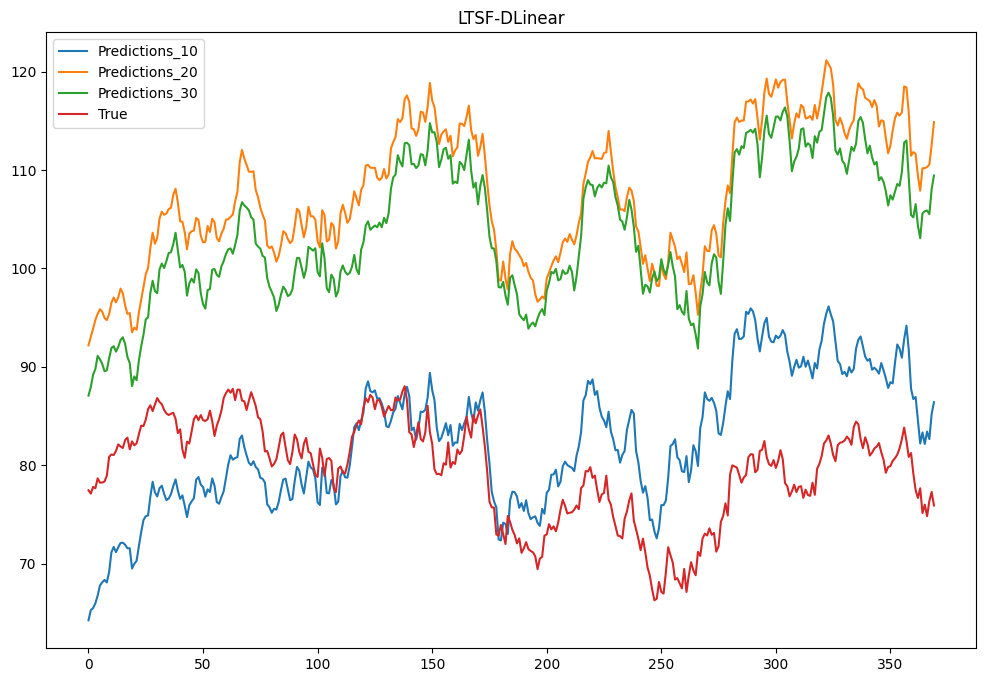

100%|██████████| 104/104 [00:00<00:00, 128.67it/s]

Test Loss: 1012.324707
torch.Size([3327, 30, 9])


In [46]:
if __name__=="__main__":
  prediction_5, prediction_10, prediction_30 = main(FORCAST_SIZE = 30, epochs = 200, tolerance = 0.0001, TRADE_END_DATE = '2023-05-05')